In [ ]:
!pip install datasets rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 16.1 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=a2b5a11961d52a4659614c653d3f7f4cca9333b3e95c1859480e522a0bb30b19
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from datasets import load_dataset

In [ ]:
from attention import AttentionLayer

In [ ]:
# Parameters
max_len_input = 100
max_len_target = 50
latent_dim = 256
embedding_dim = 300  # As per Word2Vec dimensions
dataset_name = "allenai/multinews_dense_oracle"
batch_size = 64
epochs = 10

# Load datasets
dataset = load_dataset(dataset_name)
# Increase the dataset size if computational resources permit
dataset_train = dataset['train']
dataset_val = dataset['validation']
dataset_test = dataset['test']

Generating train split:   0%|          | 0/44972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5622 [00:00<?, ? examples/s]

In [ ]:
# Convert train dataset to DataFrame
train_df = pd.DataFrame(dataset_train)

# Convert validation dataset to DataFrame
val_df = pd.DataFrame(dataset_val)

# Convert test dataset to DataFrame
test_df = pd.DataFrame(dataset_test)

print(train_df.head())

                                            document  \
0  The number of Americans seeking unemployment a...   
1  Shelly Sterling still wants to retain partial ...   
2  GAITHERSBURG, Md. (AP) — A small, private jet ...   
3  On Monday night, while the rest of the world w...   
4  Image caption A man has admitted removing anot...   

                                             summary  
0  – The unemployment rate dropped to 8.2% last m...  
1  – Shelly Sterling plans "eventually" to divorc...  
2  – A twin-engine Embraer jet that the FAA descr...  
3  – Tucker Carlson is in deep doodoo with conser...  
4  – What are the three most horrifying words in ...  


In [ ]:
train_df.drop_duplicates(subset=['document'],inplace=True)
train_df.dropna(axis=0,inplace=True)
val_df.drop_duplicates(subset=['document'],inplace=True)
val_df.dropna(axis=0,inplace=True)
test_df.drop_duplicates(subset=['document'],inplace=True)
test_df.dropna(axis=0,inplace=True)

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install lxml

In [ ]:
!pip install lxml

In [ ]:

stop_words = set(stopwords.words('english'))
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

cleaned_text_train = []
cleaned_text_val = []
cleaned_text_test = []
for t,v,te in zip(train_df['document'],val_df['document'], test_df['document']):
    cleaned_text_train.append(text_cleaner(t))
    cleaned_text_val.append(text_cleaner(v))
    cleaned_text_test.append(text_cleaner(te))

In [ ]:
train_df['summary'][:10]

0    – The unemployment rate dropped to 8.2% last m...
1    – Shelly Sterling plans "eventually" to divorc...
2    – A twin-engine Embraer jet that the FAA descr...
3    – Tucker Carlson is in deep doodoo with conser...
4    – What are the three most horrifying words in ...
5    – Calls to suicide hotlines have spiked dramat...
6    – Public apologies making headlines this week ...
7    – Education Secretary John King has a message ...
8    – A massive leak of fracking fluid poured into...
9    – Paul Gonzales' approach to dating is similar...
Name: summary, dtype: object

In [ ]:

val_df['summary'][:10]


0    – The Da Vinci Code has sold so many copies—th...
1    – A major snafu has hit benefit payments to st...
2    – Yemen-based al-Qaeda in the Arabian Peninsul...
3    – Cambridge Analytica is calling it quits. The...
4    – A lengthy report in the New York Times, base...
5    – Don Juan de Oñate sought a city of gold when...
6    – Another bad day for Anthony Weiner: Nancy Pe...
7    – An augmented reality startup is being sued f...
8    – The length of a man's index and ring fingers...
9    – A 71-year-old lawyer is suing United Airline...
Name: summary, dtype: object

In [ ]:
test_df['summary'][:10]

0    – It's a race for the governor's mansion in 11...
1    – It turns out Facebook is only guilty of abou...
2    – Not a big fan of Southern California? Neithe...
3    – Why did Microsoft buy Nokia's phone business...
4    – The Supreme Court is facing a docket of high...
5    – In 1783, after the British soldiers left New...
6    – Israel launched a round of airstrikes on Gaz...
7    – A Picasso painting that was found to have va...
8    – A dispute over the freshness of Wendy’s frie...
9    – A 27-year-old Dallas police officer died Wed...
Name: summary, dtype: object

In [ ]:

def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:
            newString=newString+i+' '
    return newString

In [ ]:
import re

def text_cleaner(text):
    newString = re.sub('"', '', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b", "", newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens = newString.split()
    newString = ''
    for i in tokens:
        if len(i) > 1:
            newString = newString + i + ' '
    return newString

# Clean text data in train_df
cleaned_text_train = [text_cleaner(text) for text in train_df['document']]
train_df['cleaned_text'] = cleaned_text_train

# Clean summary data in train_df
cleaned_summary_train = [summary_cleaner(summary) for summary in train_df['summary']]
train_df['cleaned_summary'] = cleaned_summary_train

# Clean text data in val_df
cleaned_text_val = [text_cleaner(text) for text in val_df['document']]
val_df['cleaned_text'] = cleaned_text_val

# Clean summary data in val_df
cleaned_summary_val = [summary_cleaner(summary) for summary in val_df['summary']]
val_df['cleaned_summary'] = cleaned_summary_val

# Clean text data in test_df
cleaned_text_test = [text_cleaner(text) for text in test_df['document']]
test_df['cleaned_text'] = cleaned_text_test

# Clean summary data in test_df
cleaned_summary_test = [summary_cleaner(summary) for summary in test_df['summary']]
test_df['cleaned_summary'] = cleaned_summary_test

# Remove rows with empty summaries
train_df.dropna(subset=['cleaned_summary'], inplace=True)
val_df.dropna(subset=['cleaned_summary'], inplace=True)
test_df.dropna(subset=['cleaned_summary'], inplace=True)


In [ ]:
train_df['cleaned_summary'] = train_df['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')
val_df['cleaned_summary'] = val_df['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')
test_df['cleaned_summary'] = test_df['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [ ]:


for i in range(5):
    print("Review:",train_df['cleaned_text'][i])
    print("Summary:",train_df['cleaned_summary'][i])
    print("\n")

print("break")

for i in range(5):
    print("Review:",val_df['cleaned_text'][i])
    print("Summary:",val_df['cleaned_summary'][i])
    print("\n")

print("break")

for i in range(5):
    print("Review:",test_df['cleaned_text'][i])
    print("Summary:",test_df['cleaned_summary'][i])
    print("\n")



Review: the number of americans seeking unemployment aid plummeted last week to seasonally adjusted the lowest level in more than four years the sharp drop offered hopeful sign that the job market could pick up in this friday sept photo group of veterans listen during session with one of the employers at job fair introducing veterans to careers in the security and private investigations industry associated press the labor department said thursday that weekly applications fell by to the fewest since february the four week average less volatile measure dropped by to six month low the positive figures follow report last week that said the unemployment rate fell in september to percent it was the first time since january that the rate dropped below percent labor department spokesman cautioned that the weekly applications can be volatile particularly at the start of quarter and the spokesman said one large state accounted for much of the decline the spokesman did not name the state unemploy

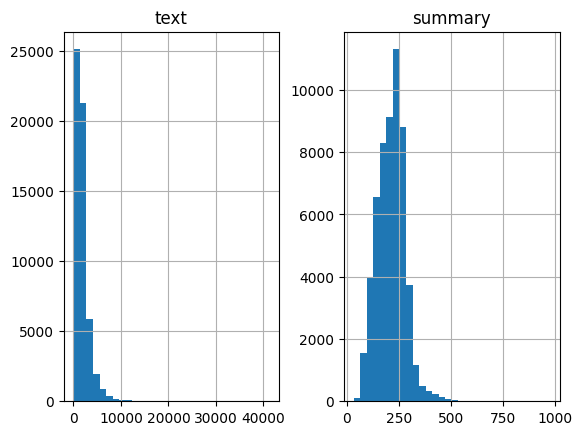

In [ ]:

import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []


# populate the lists with sentence lengths
for i in train_df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in train_df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

for i in val_df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in val_df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

for i in test_df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in test_df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [ ]:
len(text_word_count)

55996

In [ ]:
max_len_text=80
max_len_summary=10

In [ ]:
x_tr,x_val,y_tr,y_val = train_df['cleaned_text'],val_df['cleaned_text'],train_df['cleaned_summary'],val_df['cleaned_summary']

In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr)
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post')
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [ ]:

#preparing a tokenizer for summary on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr)
y_val   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [ ]:
from tensorflow.keras.initializers import Zeros

initial_state_h = Zeros()(encoder_outputs)
initial_state_c = Zeros()(encoder_outputs)

In [ ]:
from keras import backend as K
K.clear_session()
latent_dim = 500

# Encoder
encoder_inputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs)

#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#LSTM 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 80, 500)              1415625   ['input_1[0][0]']             
                                                          00                                      
                                                                                                  
 lstm (LSTM)                 [(None, 80, 500),            2002000   ['embedding[0][0]']           
                              (None, 500),                                                        
                              (None, 500)]                                                    

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

In [ ]:
from keras.optimizers import RMSprop
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy

optimizer = RMSprop()
loss_fn = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy()]

model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Checkpoint callback/content/drive/MyDrive/checkpoints
checkpoint_path = "/content/drive/MyDrive/Model_data/model_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
history = model.fit([x_tr, y_tr[:, :-1]],
                    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
                    epochs=50,
                    batch_size=512,
                    validation_data=([x_val, y_val[:, :-1]],
                                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]),
                    callbacks=[checkpoint])

# Print training and validation accuracy after each epoch
for epoch in range(50):
    print("Epoch", epoch + 1)
    print("Training Accuracy:", history.history['sparse_categorical_accuracy'][epoch])
    print("Validation Accuracy:", history.history['val_sparse_categorical_accuracy'][epoch])

Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 7.6684 - sparse_categorical_accuracy: 0.1254
Epoch 1: val_loss improved from inf to 6.93185, saving model to /content/drive/MyDrive/Model_data/model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 193s 2s/step - loss: 7.6684 - sparse_categorical_accuracy: 0.1254 - val_loss: 6.9318 - val_sparse_categorical_accuracy: 0.1584
Epoch 2/50
88/88 [==============================] - ETA: 0s - loss: 6.8646 - sparse_categorical_accuracy: 0.1521
Epoch 2: val_loss improved from 6.93185 to 6.85250, saving model to /content/drive/MyDrive/Model_data/model_checkpoint.h5
88/88 [==============================] - 199s 2s/step - loss: 6.8646 - sparse_categorical_accuracy: 0.1521 - val_loss: 6.8525 - val_sparse_categorical_accuracy: 0.1584
Epoch 3/50
88/88 [==============================] - ETA: 0s - loss: 6.7646 - sparse_categorical_accuracy: 0.1534
Epoch 3: val_loss improved from 6.85250 to 6.75308, saving model to /content/drive/MyDrive/Model_data/model_checkpoint.h5
88/88 [==============================] - 206s 2s/step - loss: 6.7646 - sparse_categorical_accuracy: 0.1534 - val_loss: 6.7531 - val_sparse_categorical_accuracy: 0.1584
Epoch 4/50
88/88 [========

In [ ]:
history = model.fit([x_tr, y_tr[:, :-1]],
                    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
                    epochs=50,
                    batch_size=512,
                    validation_data=([x_val, y_val[:, :-1]],
                                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]),
                    callbacks=[checkpoint])

# Print training and validation accuracy after each epoch
for epoch in range(50):
    print("Epoch", epoch + 1)
    print("Training Accuracy:", history.history['sparse_categorical_accuracy'][epoch])
    print("Validation Accuracy:", history.history['val_sparse_categorical_accuracy'][epoch])

Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 5.6156 - sparse_categorical_accuracy: 0.2288
Epoch 1: val_loss improved from 6.00176 to 5.98423, saving model to /content/drive/MyDrive/Model_data/model_checkpoint.h5
88/88 [==============================] - 205s 2s/step - loss: 5.6156 - sparse_categorical_accuracy: 0.2288 - val_loss: 5.9842 - val_sparse_categorical_accuracy: 0.2198
Epoch 2/50
88/88 [==============================] - ETA: 0s - loss: 5.5999 - sparse_categorical_accuracy: 0.2296
Epoch 2: val_loss improved from 5.98423 to 5.97419, saving model to /content/drive/MyDrive/Model_data/model_checkpoint.h5
88/88 [==============================] - 205s 2s/step - loss: 5.5999 - sparse_categorical_accuracy: 0.2296 - val_loss: 5.9742 - val_sparse_categorical_accuracy: 0.2212
Epoch 3/50
88/88 [==============================] - ETA: 0s - loss: 5.5839 - sparse_categorical_accuracy: 0.2310
Epoch 3: val_loss did not improve from 5.97419
88/88 [===========================